In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


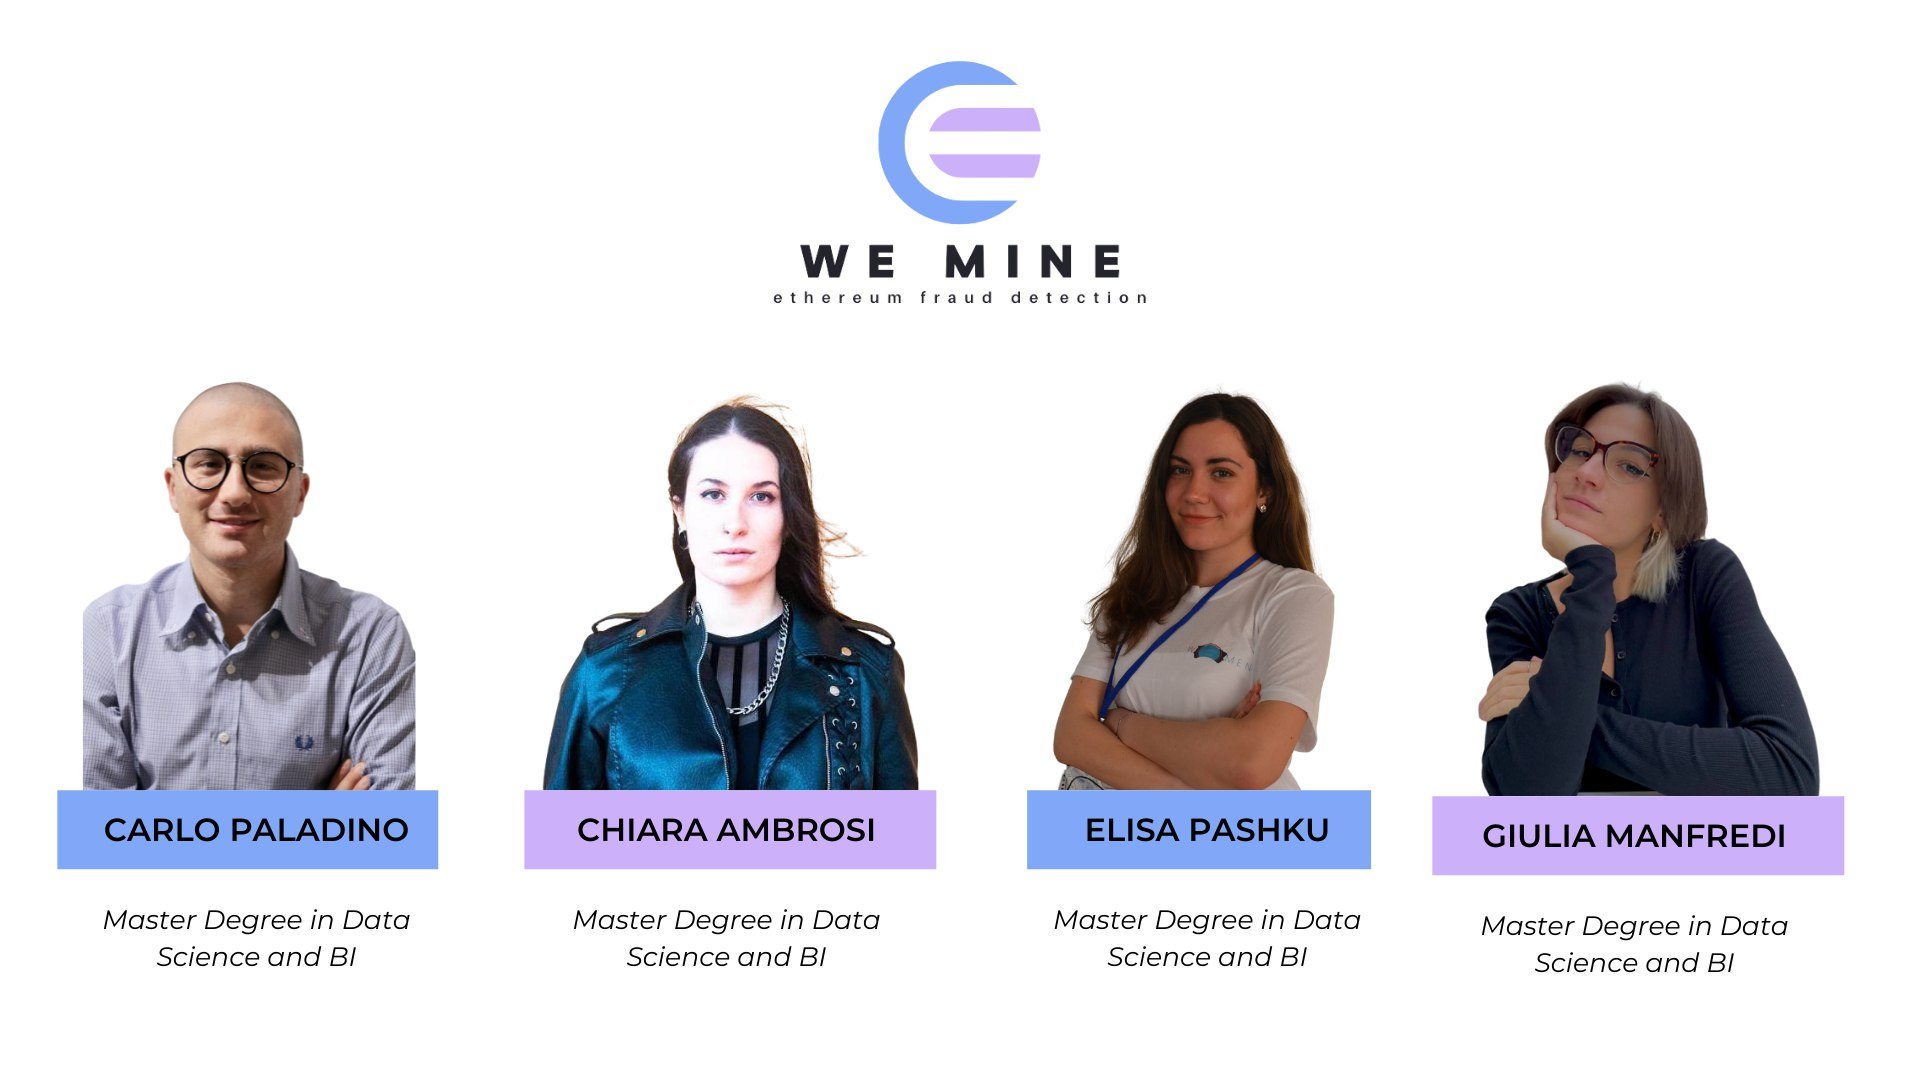

# Introduction and goals

The aim of the project is to make a binary classification on an unbalanced dataset with minority class as the fraudulent accounts, trying to understand if some of the attributes could be useful in determining whether an account has made fraudulent transactions or not, using different classification methods on different datasets.

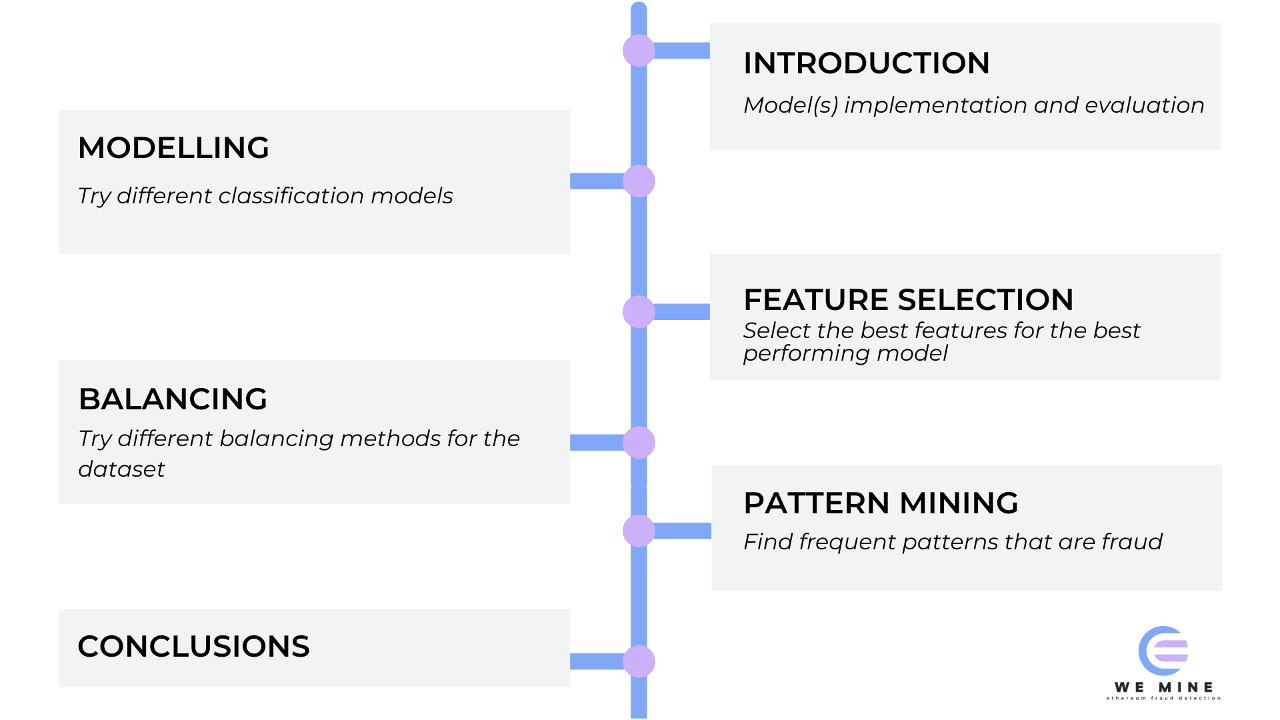

# Models implementation and evaluation

Steps performed:

1.   Selection of the best dataset for classification;
2.   Evaluation of the best classification methods on the best dataset selected before;
3.   Imbalanced learning to see if a balanced dataset could improve the classification;
4.   Pattern mining to extract rules that could give useful information about the fraudolent accounts.



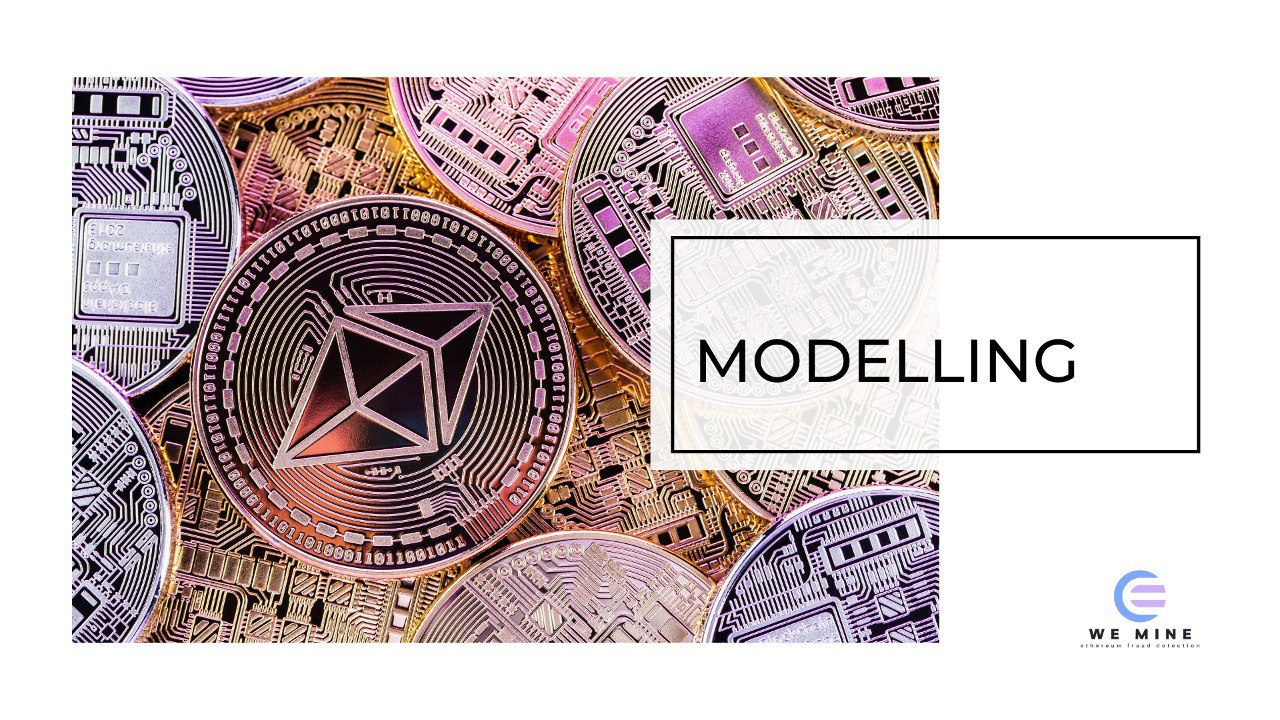

In [ ]:
# Importing the libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

**Outliers explanation (1st midterm)**

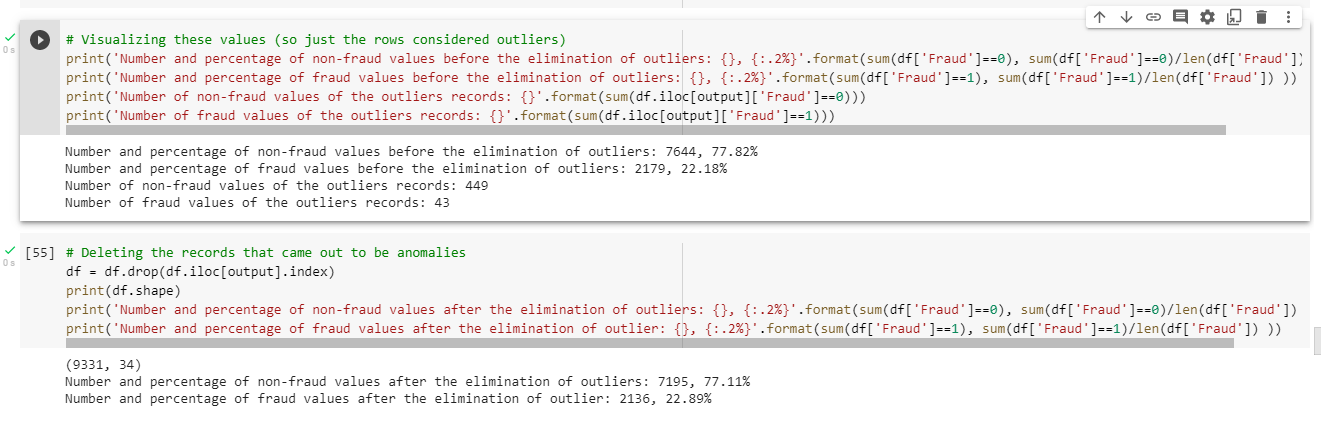

**1st Dataset**

The first dataset under analysis is the resulting one from the data cleaning task, so it is composed by 26 attributes, 9374 records and it doesn't have missing values or outliers.

In [ ]:
# Loading the dataset then showing the shape of the dataset and the first five rows of it
df = pd.read_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/clean_df.csv", index_col=0)
print(df.shape)
df.head()

(9374, 26)


,Fraud,Avg min between sent tnx,Avg min between received tnx,Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,min val sent,max val sent,total ether received,total ether balance,Total ERC20 tnxs,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 min val sent,ERC20 max val sent,ERC20 most sent token type,ERC20_most_rec_token_type,Time Diff between first and last tnx (Days)
1,0,12709.07,2958.44,94,8,0,5,14,0.000000,2.613269,0.000000,1.800000,3.085478,-0.001819,8.0,0.0,1.0,0.0,7.0,0.0,365.00000,2.260809,2.260809,154,257,845
2,0,246194.54,2434.02,2,10,0,10,2,0.113119,1.165453,0.050000,3.538616,3.589057,0.000441,8.0,0.0,0.0,0.0,8.0,0.0,442.81984,0.000000,0.000000,185,436,358
3,0,10219.60,15785.09,25,9,0,7,13,0.000000,500.000000,0.000000,450.000000,895.399559,-854.646303,14.0,0.0,2.0,0.0,11.0,0.0,11412.23068,100.000000,9029.230680,217,436,276
5,0,9900.12,375.48,2,3,0,2,1,0.724148,4.813776,4.166800,5.536916,9.704724,0.001008,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,4,3,14
6,0,69.46,629.44,25,11,0,9,20,0.049000,2.650000,0.009457,4.284785,12.079266,0.016872,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,4,3,6


The dataset has been divided into X (all the attributes except the target variable) and y (the target variable), then each has been splitted into train and test sets with a proportion of 70% for the training part and 30% for the test. Before the splitting X has been scaled with Standard Scaler.

In [ ]:
attributes = [col for col in df.columns if col != ('Fraud')]
X = df[attributes].values
y = df['Fraud']
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((6561, 25), (2813, 25))

Parameter tuning for the classification with the Decision Tree algorithm has been performed with GridSearchCV. The cross validation used is StratifiedKFold with 5 folds, in this way 5 different validation sets have been used. The measure to evaluate the best parameters is the balanced accuracy since it's an imbalanced dataset and accuracy could give results with bias.

# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state': [42]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 80, 'random_state': 42}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=80,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


The best parameters resulting from the GridSearchCV are:

*   min_samples_split = 80  (specifies the minimum number of samples required to split an internal node);
*   min_samples_leaf = 10 (specifies the minimum number of samples required to be at a leaf node);
*   max_depth = 11 (length of the longest path from the tree root to a leaf);
*   criterion = 'entropy'.

So, a decision tree based on these parameters has been built.


In [ ]:
clf = DecisionTreeClassifier(min_samples_split=80, min_samples_leaf=10, max_depth=11, criterion= 'entropy', random_state=42)
clf = clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [ ]:
for col, imp in zip(attributes, sorted(clf.feature_importances_, reverse=True)):
    print(col, imp)

Avg min between sent tnx 0.4330350621512665
Avg min between received tnx 0.191990909965843
Sent tnx 0.17814539374292268
Received Tnx 0.10476203450626025
Number of Created Contracts 0.02645719863865406
Unique Received From Addresses 0.025943917659989015
Unique Sent To Addresses 0.01955315886143396
min value received 0.008065121633609064
max value received  0.005503457377740228
min val sent 0.004049606467826007
max val sent 0.0024941389944552685
total ether received 0.0
total ether balance 0.0
 Total ERC20 tnxs 0.0
 ERC20 total Ether sent contract 0.0
 ERC20 uniq sent addr 0.0
 ERC20 uniq sent addr.1 0.0
 ERC20 uniq rec contract addr 0.0
 ERC20 min val rec 0.0
 ERC20 max val rec 0.0
 ERC20 min val sent 0.0
 ERC20 max val sent 0.0
 ERC20 most sent token type 0.0
 ERC20_most_rec_token_type 0.0
Time Diff between first and last tnx (Days) 0.0


The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results. StratiefiedKFold cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.9848266909161989


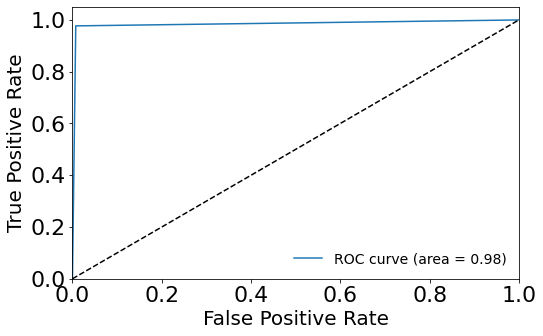

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf, X, y, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9803 (+/- 0.01)
F1-score: 0.9816 (+/- 0.01)
Precision: 0.9757 (+/- 0.02)
Recall: 0.9679 (+/- 0.02)


**2nd Dataset**

The second dataset used is the raw one, with just some cleaning procedures needed to build models on it, such as replacement of missing values and trasformation of categorical variables with Label Encoder. 
The dataset is composed by 50 attributes and 9841 records.

In [ ]:
# Loading the dataset then showing the shape of the dataset and the first five rows of it
raw = pd.read_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/transaction_dataset.csv", index_col=0)
print(raw.shape)
raw.head()

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421896,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
# Create a dictionary with columns as keys and its number of missing values
d = dict(raw.isnull().sum())
# For every column if the number of missing values is greater than 0 i append the name of the column in the list l
l=[]
for i in d.keys():
  if d[i] > 0:
    l.append(i)
# For every column in the list l, if it's numerical the missing values are replaced by the median
# Instead for the categorical variables, the missing values are replaced by the mode
for col in l[:-2]:
  raw[col] = raw[col].fillna(raw[col].median())
for col in l[-2:]:
  raw[col] = raw[col].fillna(raw[col].mode()[0])
raw.isnull().sum()

Index                                                   0
Address                                                 0
FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent

In [ ]:
# Encode labels with value between 0 and n_classes-1
# Convert all values to numbers so it's easier for the data mining algorithms
le_sent_token_type = LabelEncoder()
le_rec_token_type = LabelEncoder()
# The method fit_transform is used
raw[' ERC20 most sent token type'] = le_sent_token_type.fit_transform(raw[' ERC20 most sent token type'])
raw[' ERC20_most_rec_token_type'] = le_rec_token_type.fit_transform(raw[' ERC20_most_rec_token_type'])
raw.shape

(9841, 50)

The dataset has been divided into X (all the attributes except the target variable) and y (the target variable), then each has been splitted into train and test sets with a proportion of 70% for the training part and 30% for the test. Before the splitting X has been scaled with Standard Scaler.

In [ ]:
attributes_raw = [col for col in raw.select_dtypes(include=['float','int']).columns if col != ('FLAG')]
X_raw = raw[attributes_raw].values
y_raw = raw['FLAG']
scaler.fit(X_raw)
X_raw = scaler.transform(X_raw)

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=1, stratify=y_raw)

In [ ]:
X_raw_train.shape, X_raw_test.shape

((6888, 48), (2953, 48))

Parameter tuning for the classification with the Decision Tree algorithm has been performed with GridSearchCV. The cross validation used is StratifiedKFold with 5 folds, in this way 5 different validation sets have been used. The measure to evaluate the best parameters is the balanced accuracy since it's an imbalanced dataset and accuracy could give results with bias.

# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state': [42]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X_raw, y_raw)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 10, 'random_state': 42}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=14, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


The best parameters resulting from the GridSearchCV are:

*   min_samples_split = 10;
*   min_samples_leaf = 10;
*   max_depth = 14;
*   criterion = 'entropy'.

So, a decision tree based on these parameters has been built.

In [ ]:
clf_raw = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=14, criterion= 'entropy', random_state=42)
clf_raw = clf_raw.fit(X_raw_train, y_raw_train)

In [ ]:
y_raw_pred = clf_raw.predict(X_raw_test)
y_raw_pred_tr = clf_raw.predict(X_raw_train)

In [ ]:
for col, imp in zip(attributes_raw, sorted(clf_raw.feature_importances_, reverse=True)):
    print(col, imp)

Index 0.42660566691009266
Avg min between sent tnx 0.31408416047063276
Avg min between received tnx 0.1538201089617388
Time Diff between first and last (Mins) 0.02525156896753077
Sent tnx 0.02367013954454671
Received Tnx 0.012410669688417605
Number of Created Contracts 0.009583714864417961
Unique Received From Addresses 0.008623556412449107
Unique Sent To Addresses 0.005826354471892796
min value received 0.005717922284011652
max value received  0.0056633323408499655
avg val received 0.004001662363069568
min val sent 0.001587360456262063
max val sent 0.001476472449152753
avg val sent 0.0010835734944523246
min value sent to contract 0.0005937363204825282
max val sent to contract 0.0
avg value sent to contract 0.0
total transactions (including tnx to create contract 0.0
total Ether sent 0.0
total ether received 0.0
total ether sent contracts 0.0
total ether balance 0.0
 Total ERC20 tnxs 0.0
 ERC20 total Ether received 0.0
 ERC20 total ether sent 0.0
 ERC20 total Ether sent contract 0.0
 E

The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results.

In [ ]:
fpr_raw, tpr_raw, _ = roc_curve(y_raw_test, y_raw_pred)
roc_auc_raw = auc(fpr_raw, tpr_raw)
print(roc_auc_raw)

roc_auc_raw = roc_auc_score(y_raw_test, y_raw_pred, average=None)

0.9809001520405761


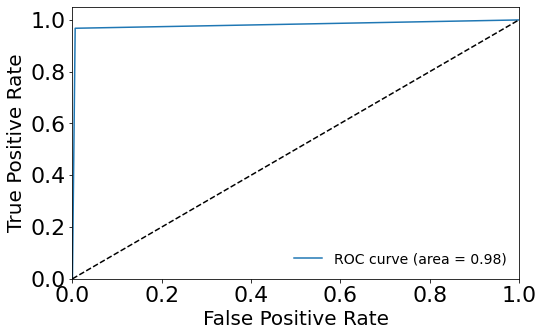

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr_raw, tpr_raw, label='ROC curve (area = %0.2f)' % (roc_auc_raw))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf_raw, X_raw, y_raw, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_raw, X_raw, y_raw, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_raw, X_raw, y_raw, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_raw, X_raw, y_raw, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9789 (+/- 0.01)
F1-score: 0.9808 (+/- 0.01)
Precision: 0.9758 (+/- 0.03)
Recall: 0.9647 (+/- 0.03)


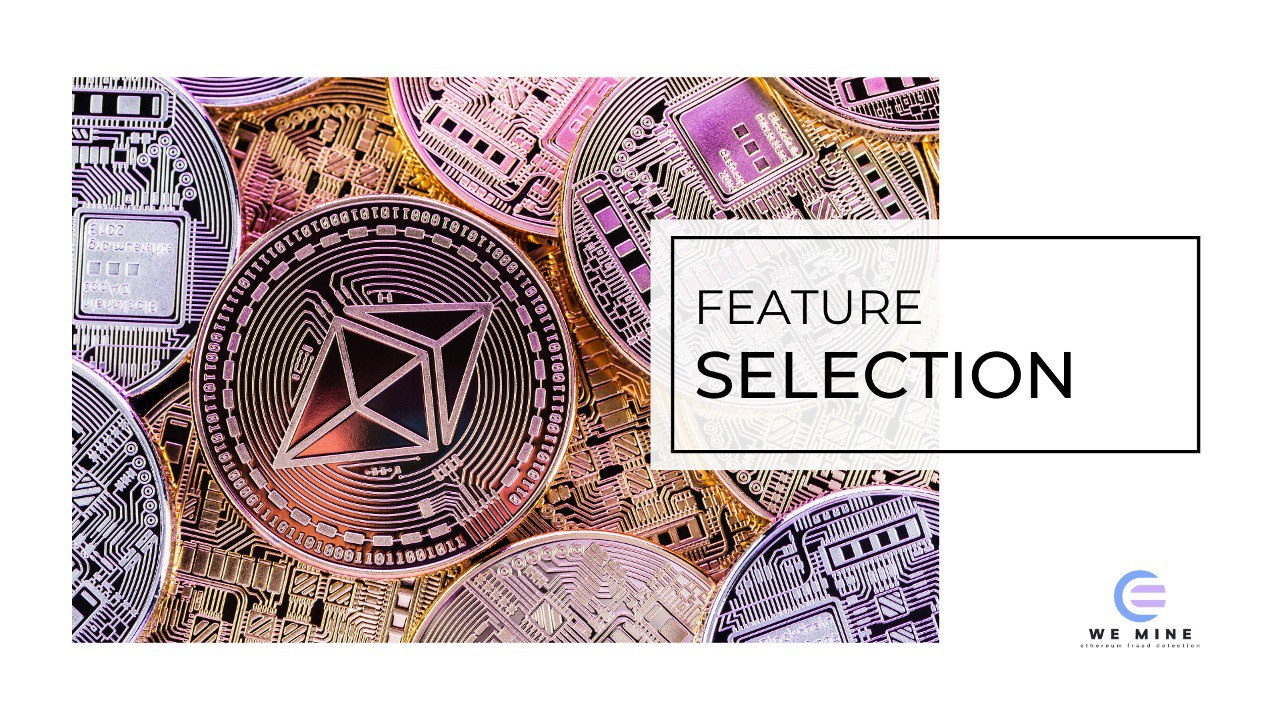

**3rd Dataset**

The third dataset used is the one resulting from the feature selection with RFECV algorithm that returns as useful for the classification just 13 variables starting with the 26 of the 1st dataset.

In [ ]:
# evaluate RFECV for classification
from sklearn.feature_selection import RFECV

In [ ]:
y = df['Fraud']
X = df.drop('Fraud', axis=1) #Fraud is what we want to predict so it has been dropped

In [ ]:
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier(random_state=42))
rfe.fit(X, y)
sel_feat = pd.DataFrame()
# summarize all features
for i in range(X.shape[1]):
	if rfe.support_[i] == True:
		print('Column: %s, Selected %s, Rank: %.3f' % (X.columns[i], rfe.support_[i], rfe.ranking_[i]))
		sel_feat[X.columns[i]] = X.iloc[:,i]

Column: Avg min between received tnx, Selected True, Rank: 1.000
Column: Sent tnx, Selected True, Rank: 1.000
Column: Unique Received From Addresses, Selected True, Rank: 1.000
Column: max value received , Selected True, Rank: 1.000
Column: total ether received, Selected True, Rank: 1.000
Column:  Total ERC20 tnxs, Selected True, Rank: 1.000
Column:  ERC20 uniq sent addr, Selected True, Rank: 1.000
Column:  ERC20 max val rec, Selected True, Rank: 1.000
Column:  ERC20 min val sent, Selected True, Rank: 1.000
Column:  ERC20 max val sent, Selected True, Rank: 1.000
Column:  ERC20 most sent token type, Selected True, Rank: 1.000
Column:  ERC20_most_rec_token_type, Selected True, Rank: 1.000
Column: Time Diff between first and last tnx (Days), Selected True, Rank: 1.000


RFECV gives as result 13 columns using Decision Tree as classificator, so for a more precise analysis the algorithm has been performed also with Random Forest and Logistic Regression as classification methods. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from tqdm import tqdm
model2selected_features = defaultdict(list)

In [ ]:
#takes too much time
for estimator in tqdm([DecisionTreeClassifier(random_state=42), 
                  RandomForestClassifier(random_state=42), 
                  LogisticRegression(random_state=42)]):
  # create pipeline
  rfe = RFECV(estimator=estimator)
  rfe.fit(X, y)

  # summarize all features
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      model2selected_features[estimator.__class__.__name__].append(df.columns[i])

100%|██████████| 3/3 [02:11<00:00, 43.86s/it]


In [ ]:
for model, selected_features in model2selected_features.items():
  print(model, len(selected_features), selected_features)

DecisionTreeClassifier 13 ['Avg min between sent tnx', 'Avg min between received tnx', 'Number of Created Contracts', 'min value received', 'max val sent', 'total ether balance', ' ERC20 total Ether sent contract', ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 most sent token type', ' ERC20_most_rec_token_type']
RandomForestClassifier 14 ['Avg min between sent tnx', 'Avg min between received tnx', 'Sent tnx', 'Number of Created Contracts', 'min value received', 'max val sent', 'total ether received', 'total ether balance', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 min val rec', ' ERC20 max val sent', ' ERC20 most sent token type', ' ERC20_most_rec_token_type']
LogisticRegression 15 ['Avg min between received tnx', 'Sent tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'min value received', 'max value received ', 'min val sent', 'total ether received', 'total ether balance', ' Total ERC20

After trying different classification algorithms the resulting columns are almost the same, so it has been decided to keep the 13 attributes in common among the three classifiers. So the resulting dataset is composed by 13 attributes and 9374 records.

In [ ]:
sel_feat

,Avg min between received tnx,Sent tnx,Unique Received From Addresses,max value received,total ether received,Total ERC20 tnxs,ERC20 uniq sent addr,ERC20 max val rec,ERC20 min val sent,ERC20 max val sent,ERC20 most sent token type,ERC20_most_rec_token_type,Time Diff between first and last tnx (Days)
1,2958.44,94,5,2.613269,3.085478,8.0,1.0,365.00000,2.260809,2.260809,154,257,845
2,2434.02,2,10,1.165453,3.589057,8.0,0.0,442.81984,0.000000,0.000000,185,436,358
3,15785.09,25,7,500.000000,895.399559,14.0,2.0,11412.23068,100.000000,9029.230680,217,436,276
5,375.48,2,2,4.813776,9.704724,0.0,0.0,0.00000,0.000000,0.000000,4,3,14
6,629.44,25,9,2.650000,12.079266,0.0,0.0,0.00000,0.000000,0.000000,4,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,631.39,4,11,12.000000,36.673777,2.0,0.0,1.33700,0.000000,0.000000,1,194,40
9837,0.00,0,0,0.000000,0.000000,1.0,0.0,13.37000,0.000000,0.000000,1,74,0
9838,2189.29,67,31,21.310000,53.070252,5.0,0.0,1500.00000,0.000000,0.000000,1,185,181
9839,0.00,0,1,0.500000,0.500000,1.0,0.0,0.00000,0.000000,0.000000,4,3,0


The dataset has been divided into X (all the attributes except the target variable) and y (the target variable), then each has been splitted into train and test sets with a proportion of 70% for the training part and 30% for the test. Before the splitting X has been scaled with Standard Scaler.

In [ ]:
X_sel = sel_feat.values
y_sel = df['Fraud']
scaler.fit(X_sel)
X_sel = scaler.transform(X_sel)
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(X_sel, y_sel, test_size=0.3, random_state=1, stratify=y_sel)

In [ ]:
X_sel_train.shape, X_sel_test.shape

((6561, 13), (2813, 13))

Parameter tuning for the classification with the Decision Tree algorithm has been performed with GridSearchCV. The cross validation used is StratifiedKFold with 5 folds, in this way 5 different validation sets have been used. The measure to evaluate the best parameters is the balanced accuracy since it's an imbalanced dataset and accuracy could give results with bias.

# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state': [42]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X_sel, y_sel)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 40, 'random_state': 42}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=40,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


The best parameters resulting from the GridSearchCV are:

*   min_samples_split = 40;
*   min_samples_leaf = 10;
*   max_depth = 11;
*   criterion = 'entropy'.

So, a decision tree based on these parameters has been built.

In [ ]:
clf_sel = DecisionTreeClassifier(min_samples_split=40, min_samples_leaf=10, max_depth=11, criterion= 'entropy', random_state=42)
clf_sel = clf_sel.fit(X_sel_train, y_sel_train)
y_sel_pred = clf_sel.predict(X_sel_test)
y_sel_pred_tr = clf_sel.predict(X_sel_train)
for col, imp in zip(attributes, sorted(clf.feature_importances_, reverse=True)):
    print(col, imp)

Avg min between sent tnx 0.4330350621512665
Avg min between received tnx 0.191990909965843
Sent tnx 0.17814539374292268
Received Tnx 0.10476203450626025
Number of Created Contracts 0.02645719863865406
Unique Received From Addresses 0.025943917659989015
Unique Sent To Addresses 0.01955315886143396
min value received 0.008065121633609064
max value received  0.005503457377740228
min val sent 0.004049606467826007
max val sent 0.0024941389944552685
total ether received 0.0
total ether balance 0.0
 Total ERC20 tnxs 0.0
 ERC20 total Ether sent contract 0.0
 ERC20 uniq sent addr 0.0
 ERC20 uniq sent addr.1 0.0
 ERC20 uniq rec contract addr 0.0
 ERC20 min val rec 0.0
 ERC20 max val rec 0.0
 ERC20 min val sent 0.0
 ERC20 max val sent 0.0
 ERC20 most sent token type 0.0
 ERC20_most_rec_token_type 0.0
Time Diff between first and last tnx (Days) 0.0


The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results.

In [ ]:
fpr, tpr, _ = roc_curve(y_sel_test, y_sel_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_sel_test, y_sel_pred, average=None)

0.9851280395131397


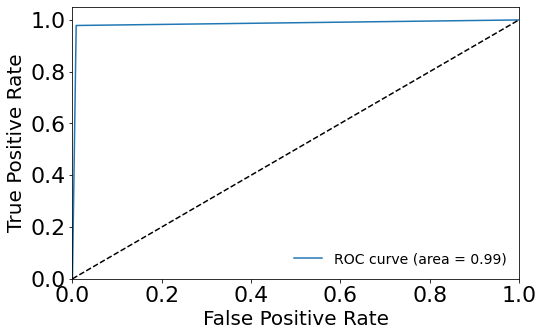

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf_sel, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sel, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sel, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_sel, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9821 (+/- 0.01)
F1-score: 0.9828 (+/- 0.01)
Precision: 0.9758 (+/- 0.02)
Recall: 0.9715 (+/- 0.03)


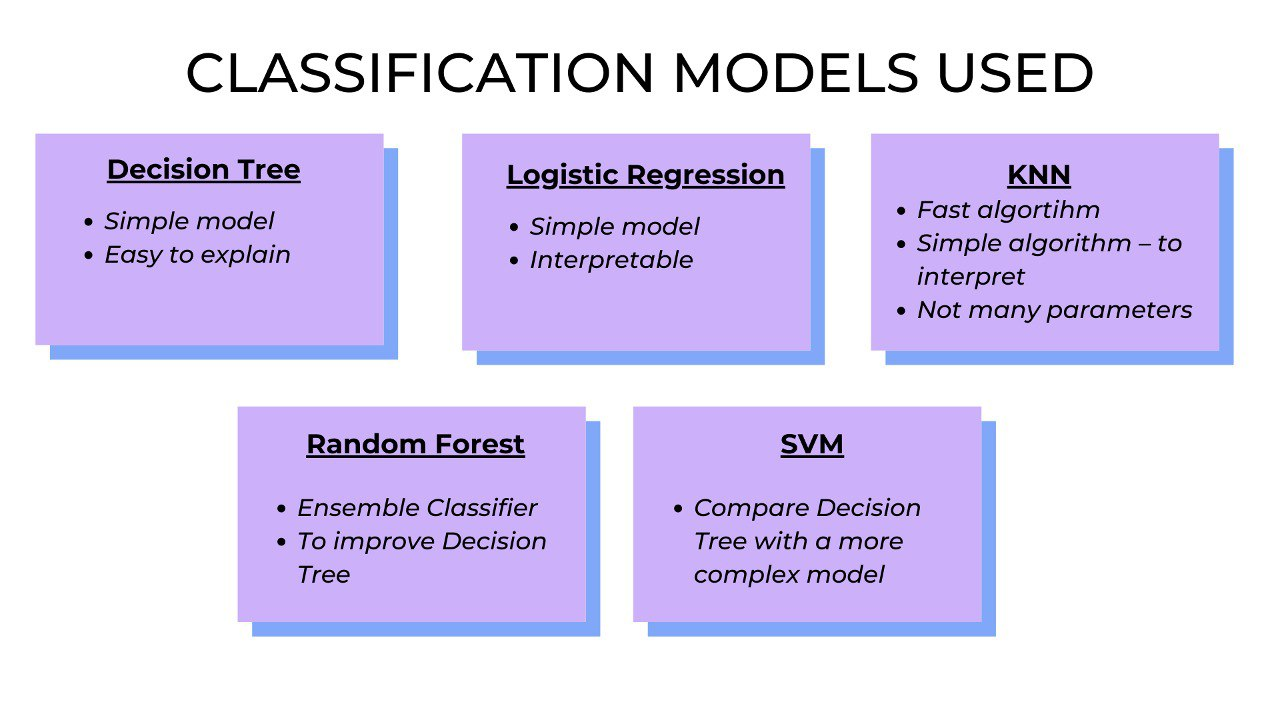

# Models implementation and evaluation on the 13 attributes dataset:

*   Decision Tree (previously shown)
*   Linear SVM
*   KNN
*   Logistic Regression
*   Random Forest



# Linear SVM

SVM is a supervised machine learning algorithm, it uses a technique called the kernel trick to transform data and then based on these transformations it finds an optimal boundary between the possible outputs.

In [ ]:
from sklearn.svm import LinearSVC

Parameter tuning for the classification with the Support Vector Machine algorithm has been performed with GridSearchCV. The cross validation used is StratifiedKFold with 5 folds, in this way 5 different validation sets have been used. The measure to evaluate the best parameters is the balanced accuracy since it's an imbalanced dataset and accuracy could give results with bias.

The parameters that we are tuning are:


*   penalty: specifies the norm used in the penalization (l1 or l2);
*   C: regularization parameter (in a range from 0 to 1);
*   loss: specifies the loss function. "hinge" is the standard SVM loss while "squared_hinge" is the square of the hinge loss.



# GridSearchCV

In [ ]:
param_list = {'penalty': ['l1','l2'],
              'loss': ['hinge', 'squared_hinge'],
              'C': np.arange(0,1,0.1),
              'random_state': [42]
             }

grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X_sel, y_sel)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
#stratified calcola da solo la validation set (5 sono le iterazioni, 5 validation set)
#scoring balanced fa un cosa piu bilanciata

{'C': 0.9, 'loss': 'hinge', 'penalty': 'l2', 'random_state': 42}
LinearSVC(C=0.9, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=42, tol=0.0001, verbose=0)


The best parameters resulting from the GridSearchCV are:

*   C = 0.9;
*   loss = hinge;
*   penalty = l2.

So, a model based on these parameters has been built.

In [ ]:
clf_SVC = LinearSVC(random_state=42, penalty="l2", C=0.9, loss="hinge")
clf_SVC.fit(X_sel, y_sel)

LinearSVC(C=0.9, loss='hinge', random_state=42)

The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results.

In [ ]:
y_sel_pred_SVC = clf_SVC.predict(X_sel_test)
fpr, tpr, _ = roc_curve(y_sel_test, y_sel_pred_SVC)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_sel_test, y_sel_pred_SVC, average=None)

0.7683068387363613


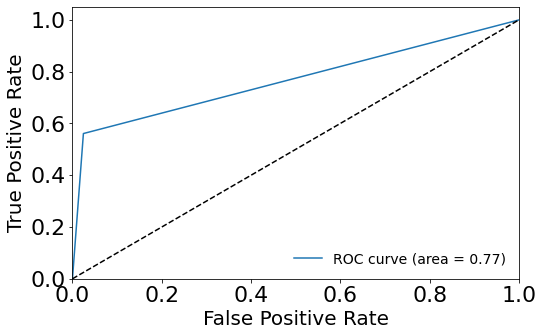

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf_SVC, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_SVC, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_SVC, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_SVC, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

#recall: lot of FN, few TP

Accuracy: 0.7736 (+/- 0.03)
F1-score: 0.8118 (+/- 0.03)
Precision: 0.9022 (+/- 0.08)
Recall: 0.5663 (+/- 0.07)


# K-Nearest Neighbors

K-nearest neighbors is a simple algorithm that stores all available records and classifies new records based on a similarity measure (e.g., distance functions).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_sel_train.shape

(6561, 13)

**Finding the best K (number of neighbors)**

To choose the best K, the error rate has been computed for the range from 70 to 90, because the square root of the number of records in the train part is 81.

Minimum error:- 0.05190188410949165 at K = 0


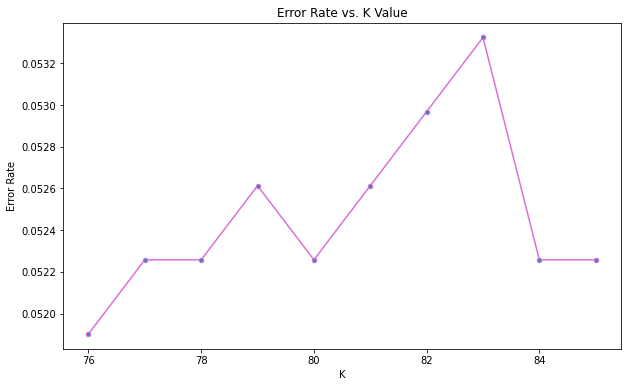

In [ ]:
error_rate = []
for i in range(76,86):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_sel_train,y_sel_train)
    pred_i = knn.predict(X_sel_test)
    error_rate.append(np.mean(pred_i != y_sel_test))

plt.figure(figsize=(10,6))
plt.plot(range(76,86),error_rate,color='orchid', 
         marker='.',markerfacecolor='steelblue', markersize=9)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

The final K chosen is 76 since has the lowest error rate. The parameter to compute the weight of each neighbor is set as "distance", so that closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [ ]:
clf_KNN = KNeighborsClassifier(n_neighbors=76, weights='distance')
clf_KNN.fit(X_sel_train, y_sel_train)

KNeighborsClassifier(n_neighbors=76, weights='distance')

The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results.

In [ ]:
y_sel_pred_KNN = clf_KNN.predict(X_sel_test)
fpr, tpr, _ = roc_curve(y_sel_test, y_sel_pred_KNN)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_sel_test, y_sel_pred_KNN, average=None)

0.9361760669015131


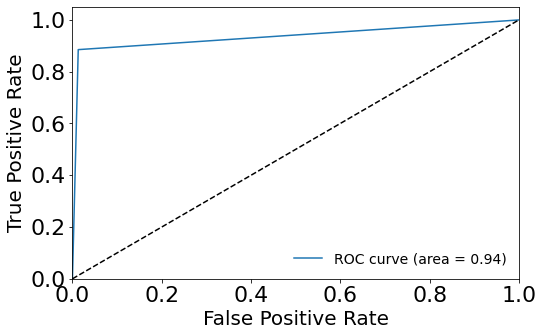

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf_KNN, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_KNN, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_KNN, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_KNN, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9351 (+/- 0.009)
F1-score: 0.9467 (+/- 0.006)
Precision: 0.9547 (+/- 0.013)
Recall: 0.8830 (+/- 0.019)


# Logistic Regression

Logistic Regression models the probabilities for classification problems with two possible outcomes.

We decided to use it because is interpretable.

In [ ]:
from sklearn.linear_model import LogisticRegression

Parameter tuning for the classification with the Logistic Regression algorithm has been performed with GridSearchCV. The cross validation used is StratifiedKFold with 5 folds, in this way 5 different validation sets have been used. The measure to evaluate the best parameters is the balanced accuracy since it's an imbalanced dataset and accuracy could give results with bias.

The parameters that we are tuning are:

*   penalty: specifies the norm of the penalty ('none': no penalty is added; 'l2': add a L2 penalty term and it is the default choice; 'l1': add a L1 penalty term; 'elasticnet': both L1 and L2 penalty terms are added);
*   C: inverse of regularization strength (must be a positive float), like in support vector machines, smaller values specify stronger regularization (in a range from 0 to 1);
*   solver: algorithm to use in the optimization problem ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga').

# GridSearchCV

In [ ]:
param_list = {'penalty': ['l1','l2', 'elasticnet','none'],
              'C': np.arange(0,1,0.1),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'random_state': [42]
             }

grid_search = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X_sel, y_sel)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
#stratified calcola da solo la validation set (5 sono le iterazioni, 5 validation set)
#scoring balanced fa un cosa piu bilanciata

{'C': 0.0, 'penalty': 'none', 'random_state': 42, 'solver': 'newton-cg'}
LogisticRegression(C=0.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=42, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)


The best parameters resulting from the GridSearchCV are:

*   C = 0.0;
*   solver = newton-cg;
*   penalty = none.

So, a model based on these parameters has been built.

In [ ]:
clf_LR = LogisticRegression(random_state=42, penalty="none", C=0.0, solver='newton-cg')
clf_LR.fit(X_sel_train, y_sel_train)

LogisticRegression(C=0.0, penalty='none', random_state=42, solver='newton-cg')

The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results.

In [ ]:
y_sel_pred_LR = clf_LR.predict(X_sel_test)
fpr, tpr, _ = roc_curve(y_sel_test, y_sel_pred_LR)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_sel_test, y_sel_pred_LR, average=None)

0.7691159827363728


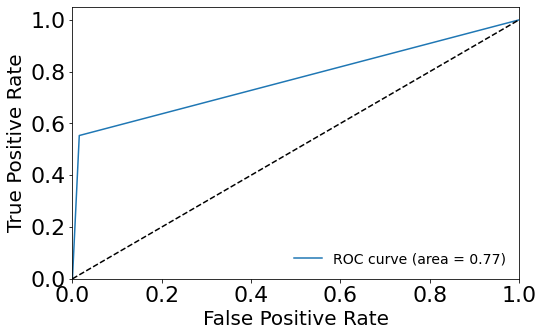

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf_LR, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_LR, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_LR, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_LR, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

#low recall

Accuracy: 0.7381 (+/- 0.032)
F1-score: 0.7795 (+/- 0.032)
Precision: 0.9282 (+/- 0.030)
Recall: 0.4879 (+/- 0.065)


# Random Forest

Random Forest is an ensemble learning classifier that fits a number of decision tree classifiers on some sub-samples of the dataset and uses the average to improve the predictive performances.

We used the Random Forest to improve the performances of the Decision Tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Parameter tuning for the classification with the Random Forest algorithm has been performed with GridSearchCV. The cross validation used is StratifiedKFold with 5 folds, in this way 5 different validation sets have been used. The measure to evaluate the best parameters is the balanced accuracy since it's an imbalanced dataset and accuracy could give results with bias.

# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state': [42]
             }

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X_sel, y_sel)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
#stratified calcola da solo la validation set (5 sono le iterazioni, 5 validation set)
#scoring balanced fa un cosa piu bilanciata

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 10, 'random_state': 42}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


The best parameters resulting from the GridSearchCV are:

*   max_depth = 11;
*   min_samples_split = 10;
*   min_samples_leaf = 10;
*   criterion = entropy.

In [ ]:
clf_RF = RandomForestClassifier(max_depth=11, min_samples_split=10, min_samples_leaf=10, criterion="entropy", random_state=42)
clf_RF.fit(X_sel, y_sel)

RandomForestClassifier(criterion='entropy', max_depth=11, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

The model has been evaluated with ROC curve visualization and 4 measures (balanced accuracy, f1 score, precision and recall) computed with a cross validation of 10 folds to have more precise results.

In [ ]:
y_sel_pred_RF = clf_RF.predict(X_sel_test)
fpr, tpr, _ = roc_curve(y_sel_test, y_sel_pred_RF)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_sel_test, y_sel_pred_RF, average=None)

0.9878373439963286


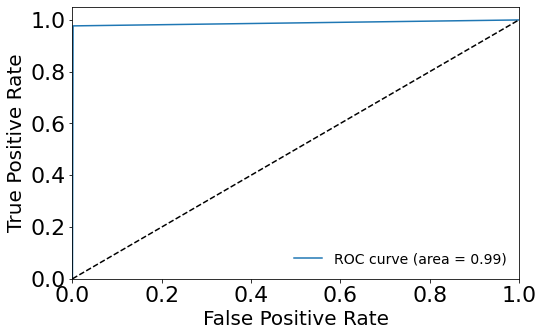

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf_RF, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_RF, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_RF, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_RF, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9804 (+/- 0.006)
F1-score: 0.9856 (+/- 0.005)
Precision: 0.9934 (+/- 0.004)
Recall: 0.9628 (+/- 0.012)


# Models implementation and evaluation on the 26 attributes dataset:

*   Decision Tree (previously shown)
*   Linear SVM
*   KNN
*   Logistic Regression
*   Random Forest


# Linear SVM

# GridSearchCV

In [ ]:
param_list = {'penalty': ['l1','l2'],
              'loss': ['hinge', 'squared_hinge'],
              'C': np.arange(0,1,0.1),
              'random_state' : [42]
             }

grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state = 42), scoring='balanced_accuracy')
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
#stratified calcola da solo la validation set (5 sono le iterazioni, 5 validation set)
#scoring balanced fa un cosa piu bilanciata

{'C': 0.8, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 42}
LinearSVC(C=0.8, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


In [ ]:
clf_SVC_26 = LinearSVC(random_state=42, penalty="l2", C=0.8, loss="squared_hinge")
clf_SVC_26.fit(X, y)

LinearSVC(C=0.8, random_state=42)

In [ ]:
scores = cross_val_score(clf_SVC_26, X, y, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_SVC_26, X, y, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_SVC_26, X, y, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf_SVC_26, X, y, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8330 (+/- 0.07)
F1-score: 0.7914 (+/- 0.08)
Precision: 0.6330 (+/- 0.26)
Recall: 0.8361 (+/- 0.22)


# K-Nearest Neighbors

In [ ]:
X_train.shape

(6561, 25)

Minimum error:- 0.0607891930323498 at K = 3


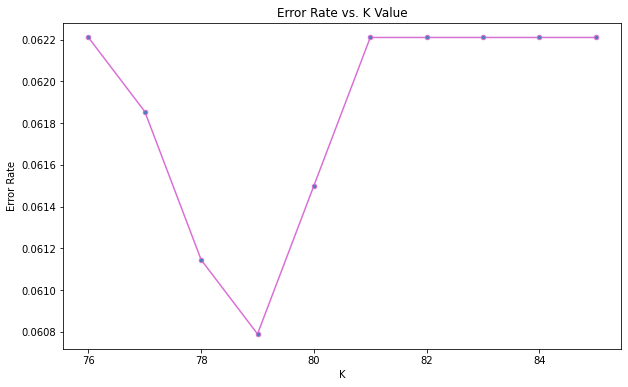

In [ ]:
error_rate = []
for i in range(76,86):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(76,86),error_rate,color='orchid', 
         marker='.',markerfacecolor='steelblue', markersize=9)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:
clf_KNN_26 = KNeighborsClassifier(n_neighbors=79, weights='distance')
clf_KNN_26.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=79, weights='distance')

In [ ]:
scores = cross_val_score(clf_KNN_26, X, y, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_KNN_26, X, y, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_KNN_26, X, y, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_KNN_26, X, y, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.8416 (+/- 0.012)
F1-score: 0.8568 (+/- 0.011)
Precision: 0.8320 (+/- 0.025)
Recall: 0.7279 (+/- 0.025)


# Logistic Regression

# GridSearchCV

In [ ]:
param_list = {'penalty': ['l1','l2', 'elasticnet','none'],
              'C': np.arange(0,1,0.1),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'random_state':[42]
             }

grid_search = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
#stratified calcola da solo la validation set (5 sono le iterazioni, 5 validation set)
#scoring balanced fa un cosa piu bilanciata

{'C': 0.1, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
clf_LR_26 = LogisticRegression(random_state=42, penalty="l1", C=0.1, solver='liblinear')
clf_LR_26.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

In [ ]:
scores = cross_val_score(clf_LR_26, X, y, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_LR_26, X, y, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_LR_26, X, y, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_LR_26, X, y, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.6941 (+/- 0.045)
F1-score: 0.7309 (+/- 0.049)
Precision: 0.9206 (+/- 0.036)
Recall: 0.3988 (+/- 0.093)


# Random Forest

# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state': [42]
             }

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_list, cv=StratifiedKFold(5, random_state=42), scoring='balanced_accuracy')
grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 10, 'random_state': 42}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [ ]:
clf_RF_26 = RandomForestClassifier(max_depth=14, min_samples_split=10, min_samples_leaf=10, criterion="gini", random_state=42)
clf_RF_26.fit(X, y)

RandomForestClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=10,
                       random_state=42)

In [ ]:
scores = cross_val_score(clf_RF_26, X, y, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_RF_26, X, y, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_RF_26, X, y, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_RF_26, X, y, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9800 (+/- 0.007)
F1-score: 0.9856 (+/- 0.004)
Precision: 0.9948 (+/- 0.003)


**Evaluation of the classifiers**

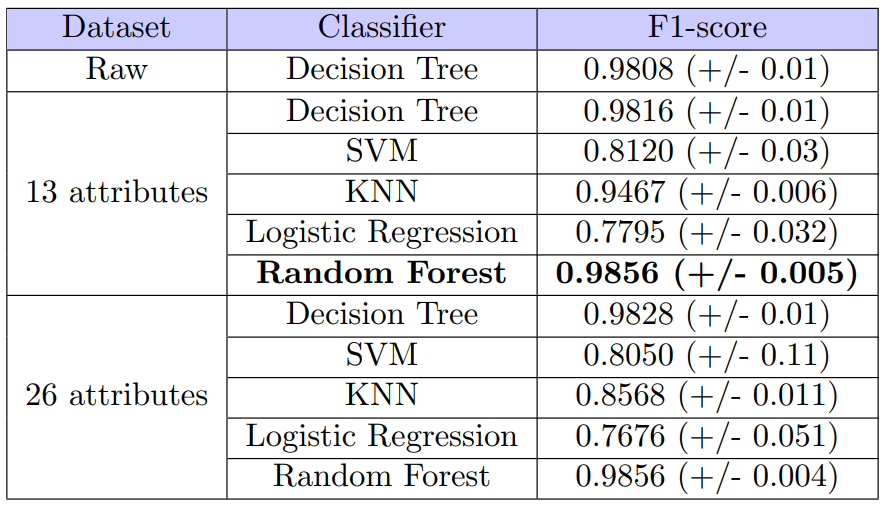

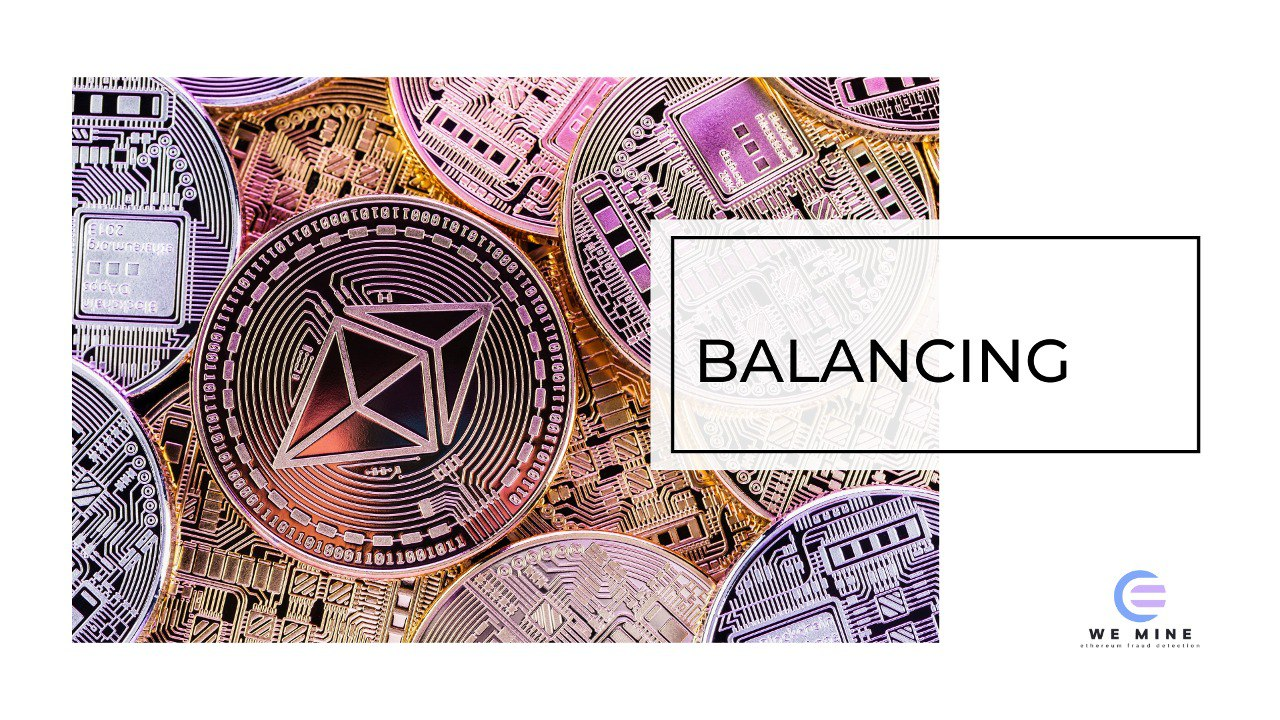

# Balancing

In this section the dataset will be balanced with different methods to see if the classification can be improved:


*   SMOTE (over sampling method);
*   CNN (under sampling method);
*   Random Under Sampling;
*   Random Over Sampling.

For the evaluation of the best balancing method a Decision Tree has been built for each balanced dataset created.



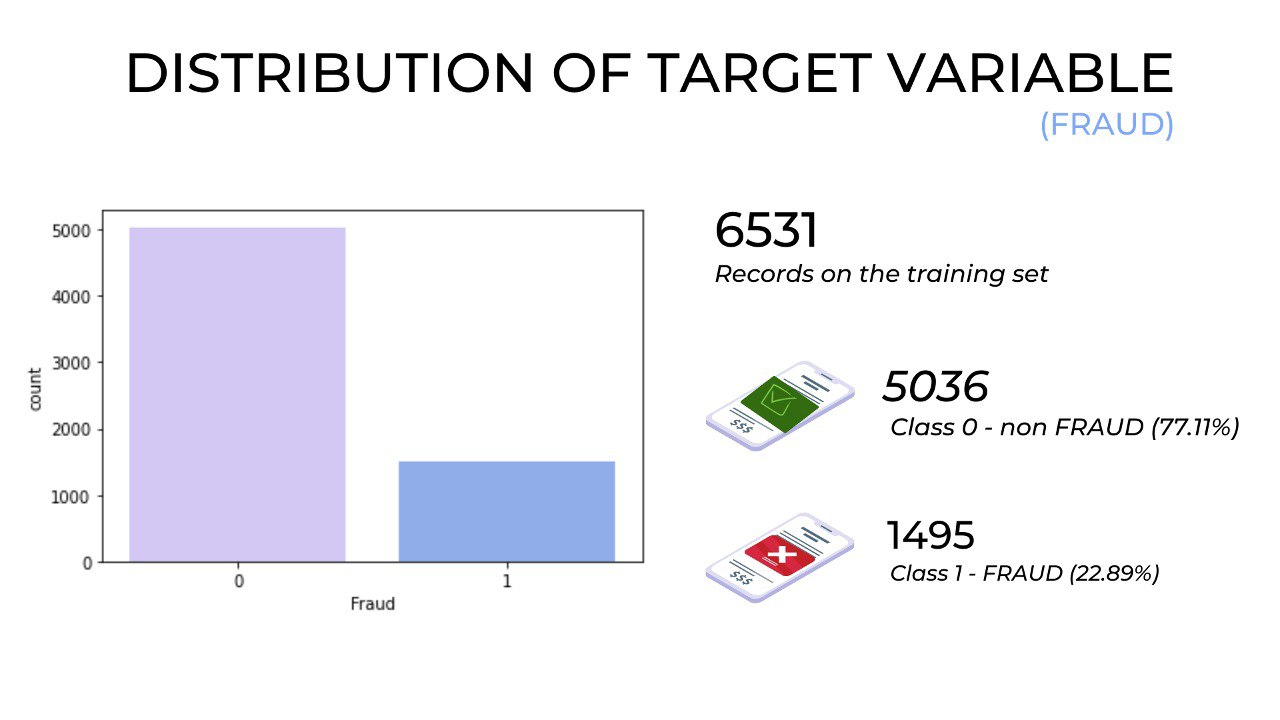

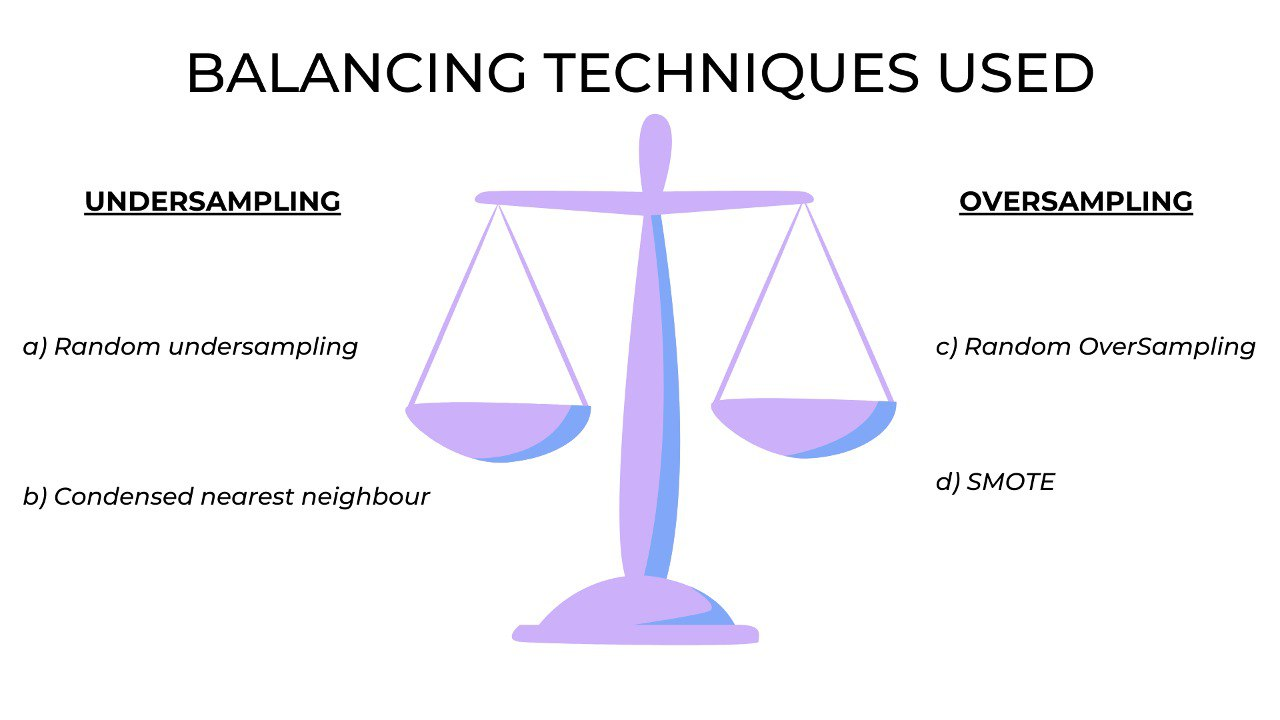

In [ ]:
sel_feat = pd.read_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/14_df.csv", index_col=0)
attributes = [col for col in sel_feat.columns if col != ('Fraud')]
X_sel = sel_feat[attributes].values
y_sel = sel_feat['Fraud']
scaler.fit(X_sel)
X_sel = scaler.transform(X_sel)
X_sel_train, X_sel_test, y_sel_train, y_sel_test = train_test_split(X_sel, y_sel, test_size=0.3, random_state=1, stratify=y_sel)

In [ ]:
X_sel_train.shape

(6561, 13)

# Random Undersampling

It randomly removes instances from the majority class, balancing it with the minority class. Anyway, this technique could increase the variance of the classifier and potentially discard useful and important instances.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_res_rus, y_res_rus = rus.fit_resample(X_sel_train, y_sel_train)
print('Resampled dataset shape %s' % y_res_rus.shape)

Resampled dataset shape 3050


# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state':[22]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=22), param_grid=param_list, cv=StratifiedKFold(5,shuffle=False), scoring='balanced_accuracy')
grid_search.fit(X_res_rus, y_res_rus)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 10, 'random_state': 22}
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       min_samples_split=10, random_state=22)


In [ ]:
clf_rus = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=8, criterion= 'entropy', random_state=22)
clf_rus = clf_rus.fit(X_res_rus, y_res_rus)

In [ ]:
scores = cross_val_score(clf_rus, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_rus, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_rus, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_rus, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9799 (+/- 0.006)
F1-score: 0.9827 (+/- 0.005)
Precision: 0.9819 (+/- 0.010)
Recall: 0.9651 (+/- 0.010)


# Condensed Nearest Neighbors

The idea of CNN algorithm is to perform a smart undersampling by removing the majority points having as k-nearest neighbor a minority point.

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour

As parameters n_neighbors (size of the neighbourhood to consider to compute the nearest neighborss) has been set to 81 since it's the square root of the number of records in the training set and n_jobs has been set to -1 to use all the CPUs.

In [ ]:
# takes too much time
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1, n_neighbors=81)
X_res_cnn, y_res_cnn = cnn.fit_resample(X_sel_train, y_sel_train)
print('Resampled dataset shape %s' % y_res_cnn.shape)

Resampled dataset shape 2141


# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state':[23]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=23), param_grid=param_list, cv=StratifiedKFold(5, shuffle=False), scoring='balanced_accuracy')
grid_search.fit(X_res_cnn, y_res_cnn)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 40, 'random_state': 23}
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       min_samples_split=40, random_state=23)


In [ ]:
clf_cnn = DecisionTreeClassifier(min_samples_split=40, min_samples_leaf=10, max_depth=8, criterion= 'entropy', random_state=23)
clf_cnn = clf_cnn.fit(X_res_cnn, y_res_cnn)

In [ ]:
scores = cross_val_score(clf_cnn, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_cnn, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_cnn, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_cnn, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9804 (+/- 0.005)
F1-score: 0.9826 (+/- 0.004)
Precision: 0.9797 (+/- 0.010)
Recall: 0.9670 (+/- 0.011)


# Random Oversampling

It randomly selects instances in the minority class and replaces them.
Duplicating examples from the minority class in the training set could lead to overfitting for some models.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_res_ros, y_res_ros = ros.fit_resample(X_sel_train, y_sel_train)
print('Resampled dataset shape %s' % y_res_ros.shape)

Resampled dataset shape 10072


# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state':[21]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=21), param_grid=param_list, cv=StratifiedKFold(5, shuffle=False), scoring='balanced_accuracy')
grid_search.fit(X_res_ros, y_res_ros)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 10, 'random_state': 21}
DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=10,
                       min_samples_split=10, random_state=21)


In [ ]:
clf_ros = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=14, criterion= 'entropy', random_state=21)
clf_ros = clf_ros.fit(X_res_ros, y_res_ros)

In [ ]:
scores = cross_val_score(clf_ros, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_ros, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_ros, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_ros, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9834 (+/- 0.004)
F1-score: 0.9838 (+/- 0.003)
Precision: 0.9766 (+/- 0.005)
Recall: 0.9738 (+/- 0.009)


# SMOTE

The idea of SMOTE algorithm is to oversample the minority class by adding points through interpolation: selecting two points belonging to the minority and randomly generate a new point among them, so it works in the feature space.

As parameters k_neighbors (number of nearest neighbours to be used to construct synthetic samples) has been set to 81 since it's the square root of the number of records in the training set.

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors = 81)
X_res_smote, y_res_smote = sm.fit_resample(X_sel_train, y_sel_train)
print('Resampled dataset shape %s' % y_res_smote.shape)

Resampled dataset shape 10072


# GridSearchCV

In [ ]:
param_list = {'max_depth': range(5,20,3),
              'min_samples_split': range(10,100,10),
              'min_samples_leaf': range(10,100,10),
              'criterion': ['gini', 'entropy'],
              'random_state':[24]
             }

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=24), param_grid=param_list, cv=StratifiedKFold(5, shuffle=False), scoring='balanced_accuracy')
grid_search.fit(X_res_smote, y_res_smote)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 10, 'random_state': 24}
DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=10,
                       min_samples_split=10, random_state=24)


In [ ]:
clf_smote = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=10, max_depth=14, criterion= 'entropy', random_state=24)
clf_smote = clf_smote.fit(X_res_smote, y_res_smote)

In [ ]:
scores = cross_val_score(clf_smote, X_sel, y_sel, cv=StratifiedKFold(10), scoring='balanced_accuracy')
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_smote, X_sel, y_sel, cv=StratifiedKFold(10), scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_smote, X_sel, y_sel, cv=StratifiedKFold(10), scoring='precision')
print('Precision: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf_smote, X_sel, y_sel, cv=StratifiedKFold(10), scoring='recall')
print('Recall: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.9831 (+/- 0.005)
F1-score: 0.9837 (+/- 0.003)
Precision: 0.9766 (+/- 0.005)
Recall: 0.9734 (+/- 0.010)


#Evaluation of the best balancing method
 

 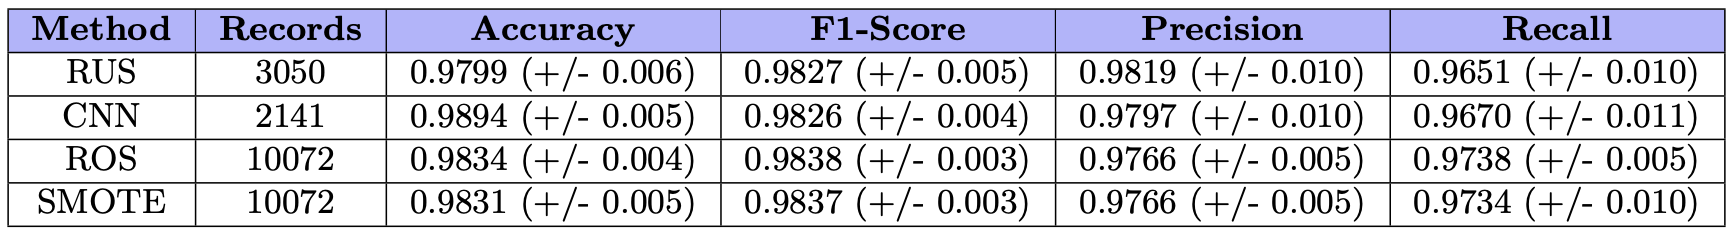

SMOTE can be considered the best balancing method since the evaluation of the Decision Tree built on the resulting dataset gives the best performances, especially for the F1-score, among all the balancing techniques. This even if the ROS gives slightly higher measures, because ROS could lead to some imperfections in the creation of the balanced dataset, so SMOTE is the safest option. Anyway, they still have lower values considering the unbalanced dataset, for this reason it has been decided to keep working on the unbalanced dataset with 13 features.

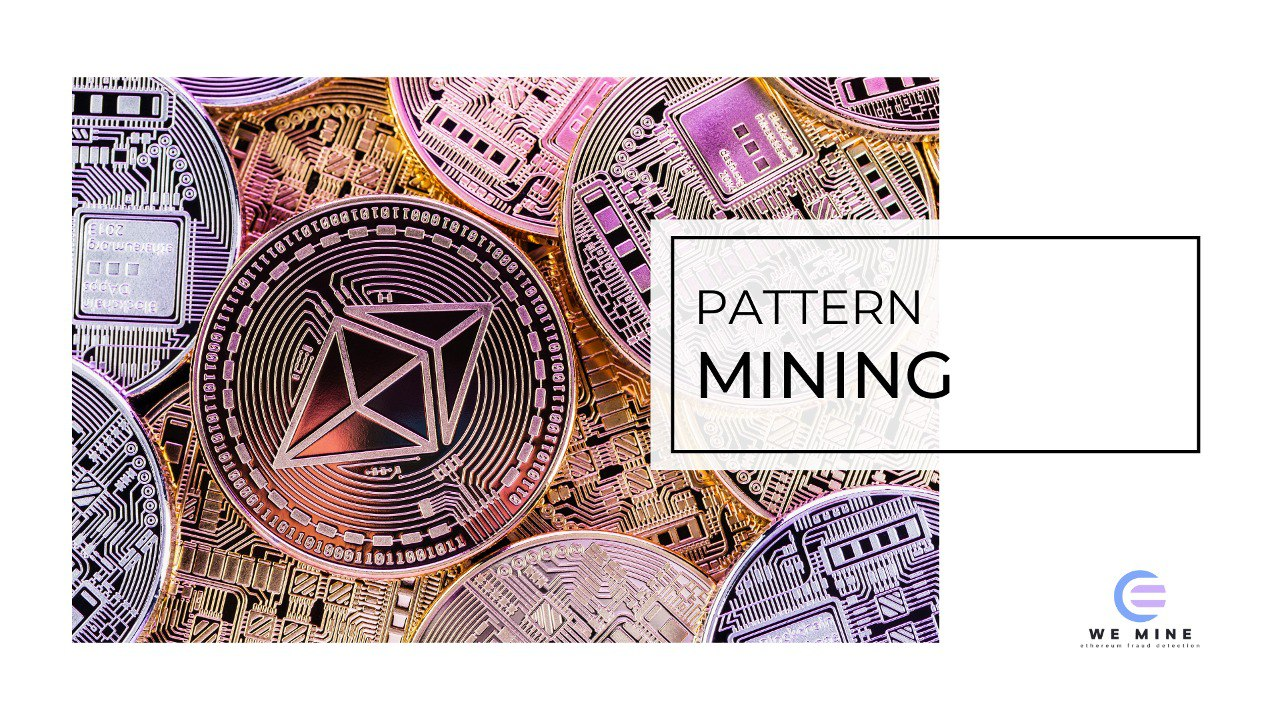

# Pattern Mining

The aim of this section is to extract the patterns that lead to fraudulent accounts to understand if there are specific attributes that could identify frauds.

As pattern mining algorithm, apriori has been used from the fim library.

The Apriori algorithm uses frequent itemsets to generate association rules, and it is designed to work on the databases that contain transactions.

In [ ]:
!pip install PyFIM

In [ ]:
from fim import apriori

Since the features have a lot of unique values the min and max have been found in order to divide the values into bins.

In [ ]:
for i in sel_feat.columns:
  print(i, min(sel_feat[i]), max(sel_feat[i]), sel_feat[i].nunique())

Avg min between received tnx 0.0 264489.01 5807
Sent tnx 0 2671 439
Unique Received From Addresses 0 2001 131
max value received  0.0 18998.0 5995
total ether received 0.0 121766.4719 6320
 Total ERC20 tnxs 0.0 2554.0 204
 ERC20 uniq sent addr 0.0 140.0 56
 ERC20 max val rec 0.0 21000000000.0 2399
 ERC20 min val sent 0.0 100000000.0 423
 ERC20 max val sent 0.0 112000000000.0 945
 ERC20 most sent token type 0 304 264
 ERC20_most_rec_token_type 0 465 398
Time Diff between first and last tnx (Days) 0 1133 824
Fraud 0 1 2


For the division in bins each columns has been divided into 4 bins except for:
*   "Avg min between received tnx": divided in 5 bins for one day, one week, one month, six months and more than six months;
*   "Time Diff between first and last tnx (Days)": divided into 6 bins for one month, six months, one year, two years and more than two years.

In [ ]:
new_df = pd.DataFrame()

In [ ]:
new_df = pd.DataFrame()
new_df['Avg min between received tnx Bin'] = pd.cut(sel_feat['Avg min between received tnx'].astype(int), [0,1440,10080,43200,259200,264490], right=False)
new_df['Sent tnx Bin'] = pd.cut(sel_feat['Sent tnx'].astype(int), 4, right=False)
new_df['Unique Received From Addresses Bin'] = pd.cut(sel_feat['Unique Received From Addresses'].astype(int), 4, right=False)
new_df['max value received Bin'] = pd.cut(sel_feat['max value received '].astype(int), 4, right=False)
new_df['total ether received Bin'] = pd.cut(sel_feat['total ether received'].astype(int), 4, right=False)
new_df[' Total ERC20 tnxs Bin'] = pd.cut(sel_feat[' Total ERC20 tnxs'].astype(int), 4, right=False)
new_df[' ERC20 uniq sent addr Bin'] = pd.cut(sel_feat[' ERC20 uniq sent addr'].astype(int), 4, right=False)
new_df[' ERC20 max val rec Bin'] = pd.cut(sel_feat[' ERC20 max val rec'].astype(int), 4, right=False)
new_df[' ERC20 min val sent Bin'] = pd.cut(sel_feat[' ERC20 min val sent'].astype(int), 4, right=False)
new_df[' ERC20 max val sent Bin'] = pd.cut(sel_feat[' ERC20 max val sent'].astype(int), 4, right=False)
new_df['Time Diff between first and last tnx (Days) Bin'] = pd.cut(sel_feat['Time Diff between first and last tnx (Days)'].astype(int), [0,30,180,365,730,1095,1134], right=False)

In [ ]:
new_df['Avg min between received tnx Bin'] = new_df['Avg min between received tnx Bin'].astype(str) + '_Avg min between received tnx Bin'
new_df['Sent tnx Bin'] = new_df['Sent tnx Bin'].astype(str) + '_Sent tnx Bin'
new_df['Unique Received From Addresses Bin'] = new_df['Unique Received From Addresses Bin'].astype(str) + '_Unique Received From Addresses Bin'
new_df['max value received Bin'] = new_df['max value received Bin'].astype(str) + '_max value received Bin'
new_df['total ether received Bin'] = new_df['total ether received Bin'].astype(str) + '_total ether received Bin'
new_df[' Total ERC20 tnxs Bin'] = new_df[' Total ERC20 tnxs Bin'].astype(str) + '_Total ERC20 tnxs Bin'
new_df[' ERC20 uniq sent addr Bin'] = new_df[' ERC20 uniq sent addr Bin'].astype(str) + '_ERC20 uniq sent addr Bin'
new_df[' ERC20 max val rec Bin'] = new_df[' ERC20 max val rec Bin'].astype(str) + '_ERC20 max val rec Bin'
new_df[' ERC20 min val sent Bin'] = new_df[' ERC20 min val sent Bin'].astype(str) + '_ERC20 min val sent Bin'
new_df[' ERC20 max val sent Bin'] = new_df[' ERC20 max val sent Bin'].astype(str) + '_ERC20 max val sent Bin'
new_df['Time Diff between first and last tnx (Days) Bin'] = new_df['Time Diff between first and last tnx (Days) Bin'].astype(str) + '_Time Diff between first and last tnx (Days) Bin'

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Jovian/ethereum-fraud-detection/transaction_dataset.csv", index_col=0)
# Create a dictionary with columns as keys and its number of missing values
d = dict(raw.isnull().sum())
#print(d)
# For every column if the number of missing values is greater than 0 i append the name of the column in the list l
l=[]
for i in d.keys():
  if d[i] > 0:
    l.append(i)
# For every column in the list l, if it's numerical the missing values are replaced by the median
# Instead for the categorical variables, the missing values are replaced by the mode
for col in l[:-2]:
  raw[col] = raw[col].fillna(raw[col].median())
for col in l[-2:]:
  raw[col] = raw[col].fillna(raw[col].mode()[0])

In [ ]:
new_df[' ERC20_most_rec_token_type'] = raw[' ERC20_most_rec_token_type']
new_df[' ERC20 most sent token type'] = raw[' ERC20 most sent token type']
new_df['Fraud'] = df['Fraud']

In [ ]:
new_df.head()

,Avg min between received tnx Bin,Sent tnx Bin,Unique Received From Addresses Bin,max value received Bin,total ether received Bin,Total ERC20 tnxs Bin,ERC20 uniq sent addr Bin,ERC20 max val rec Bin,ERC20 min val sent Bin,ERC20 max val sent Bin,Time Diff between first and last tnx (Days) Bin,ERC20_most_rec_token_type,ERC20 most sent token type,Fraud
1,"[1440, 10080)_Avg min between received tnx Bin","[0.0, 667.75)_Sent tnx Bin","[0.0, 500.25)_Unique Received From Addresses Bin","[0.0, 4749.5)_max value received Bin","[0.0, 30441.5)_total ether received Bin","[0.0, 638.5)_Total ERC20 tnxs Bin","[0.0, 35.0)_ERC20 uniq sent addr Bin","[0.0, 5250000000.0)_ERC20 max val rec Bin","[0.0, 25000000.0)_ERC20 min val sent Bin","[0.0, 28000000000.0)_ERC20 max val sent Bin","[730, 1095)_Time Diff between first and last t...",Livepeer Token,Livepeer Token,0
2,"[1440, 10080)_Avg min between received tnx Bin","[0.0, 667.75)_Sent tnx Bin","[0.0, 500.25)_Unique Received From Addresses Bin","[0.0, 4749.5)_max value received Bin","[0.0, 30441.5)_total ether received Bin","[0.0, 638.5)_Total ERC20 tnxs Bin","[0.0, 35.0)_ERC20 uniq sent addr Bin","[0.0, 5250000000.0)_ERC20 max val rec Bin","[0.0, 25000000.0)_ERC20 min val sent Bin","[0.0, 28000000000.0)_ERC20 max val sent Bin","[180, 365)_Time Diff between first and last tn...",XENON,None,0
3,"[10080, 43200)_Avg min between received tnx Bin","[0.0, 667.75)_Sent tnx Bin","[0.0, 500.25)_Unique Received From Addresses Bin","[0.0, 4749.5)_max value received Bin","[0.0, 30441.5)_total ether received Bin","[0.0, 638.5)_Total ERC20 tnxs Bin","[0.0, 35.0)_ERC20 uniq sent addr Bin","[0.0, 5250000000.0)_ERC20 max val rec Bin","[0.0, 25000000.0)_ERC20 min val sent Bin","[0.0, 28000000000.0)_ERC20 max val sent Bin","[180, 365)_Time Diff between first and last tn...",XENON,Raiden,0
5,"[0, 1440)_Avg min between received tnx Bin","[0.0, 667.75)_Sent tnx Bin","[0.0, 500.25)_Unique Received From Addresses Bin","[0.0, 4749.5)_max value received Bin","[0.0, 30441.5)_total ether received Bin","[0.0, 638.5)_Total ERC20 tnxs Bin","[0.0, 35.0)_ERC20 uniq sent addr Bin","[0.0, 5250000000.0)_ERC20 max val rec Bin","[0.0, 25000000.0)_ERC20 min val sent Bin","[0.0, 28000000000.0)_ERC20 max val sent Bin","[0, 30)_Time Diff between first and last tnx (...",0,0,0
6,"[0, 1440)_Avg min between received tnx Bin","[0.0, 667.75)_Sent tnx Bin","[0.0, 500.25)_Unique Received From Addresses Bin","[0.0, 4749.5)_max value received Bin","[0.0, 30441.5)_total ether received Bin","[0.0, 638.5)_Total ERC20 tnxs Bin","[0.0, 35.0)_ERC20 uniq sent addr Bin","[0.0, 5250000000.0)_ERC20 max val rec Bin","[0.0, 25000000.0)_ERC20 min val sent Bin","[0.0, 28000000000.0)_ERC20 max val sent Bin","[0, 30)_Time Diff between first and last tnx (...",0,0,0


To extract the rules for the Apriori algorithm the baskets have been created.

In [ ]:
baskets = new_df.values.tolist()

Parameters:


*   supp (support) = 10, is the minimum support for the itemsets;
*   zmin = 2, 3 and 4, the minimum number of items inside a itemset;
*   zmax = 2, 3 and 4, the maximum number of items inside a itemset;
*   target = "r", to extract rules;
*   conf (confidence) = 90, to extract rules with confidence higher than 90%;
*   report = "C", to have as output confidence in percentage.



In [ ]:
rules = apriori(baskets, supp=10, zmin=2, zmax=2, target='r', conf=90, report='C') 

In [ ]:
countN = 0
countF = 0
for r in rules:
    if r[0] == 0:
        countN = countN +1
    if r[0] == 1:
      print(r)
      countF = countF +1
print(countN)
print(countF)

(1, (' ',), 99.91749174917491)
5
1


In the cell above it can be seen that with almost 100% of confidence the most used token type for fraudulent accounts is not specified, but just a blank space. This means that if this type of token is found in the dataset, the class will be with a high probability a fraud.

In [ ]:
rules = apriori(baskets, supp=10, zmin=3, zmax=3, target='r', conf=90, report='C') 

In [ ]:
countN = 0
countF = 0
for r in rules:
    if r[0] == 0:
        countN = countN +1
    if r[0] == 1:
      print(r)
      countF = countF +1
print(countN)
print(countF)

(1, (' ', '[0, 1440)_Avg min between received tnx Bin'), 100.0)
(1, (' ', '[0.0, 667.75)_Sent tnx Bin'), 99.91749174917491)
(1, (' ', '[0.0, 35.0)_ERC20 uniq sent addr Bin'), 99.91749174917491)
(1, (' ', '[0.0, 4749.5)_max value received Bin'), 99.91694352159467)
(1, (' ', '[0.0, 30441.5)_total ether received Bin'), 99.91742361684558)
(1, (' ', '[0.0, 500.25)_Unique Received From Addresses Bin'), 99.91721854304636)
(1, (' ', '[0.0, 638.5)_Total ERC20 tnxs Bin'), 99.91749174917491)
(1, (' ', '[0.0, 25000000.0)_ERC20 min val sent Bin'), 99.91749174917491)
(1, (' ', '[0.0, 28000000000.0)_ERC20 max val sent Bin'), 99.91749174917491)
(1, (' ', '[0.0, 5250000000.0)_ERC20 max val rec Bin'), 99.91749174917491)
45
10


The first rule highlights the fact that if in a record that has token type "blank" and the average time (in minutes) between received transactions is less than a day, with a 100% confidence the class will be fraud.

In the other rules the confidence is a bit lower than 100%, but it can be noticed that all of them have the "blank" token type and low values for the attributes, because they all fall within the first bin. So lower values could differentiate frauds from non frauds.

In [ ]:
rules = apriori(baskets, supp=10, zmin=4, zmax=4, target='r', conf=90, report='C') 

In [ ]:
countN = 0
countF = 0
for r in rules:
    if r[0] == 0:
        countN = countN +1
    if r[0] == 1:
      print(r)
      countF = countF +1
print(countN)
print(countF)

(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 667.75)_Sent tnx Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 35.0)_ERC20 uniq sent addr Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 4749.5)_max value received Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 30441.5)_total ether received Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 500.25)_Unique Received From Addresses Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 638.5)_Total ERC20 tnxs Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 25000000.0)_ERC20 min val sent Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 28000000000.0)_ERC20 max val sent Bin'), 100.0)
(1, (' ', '[0, 1440)_Avg min between received tnx Bin', '[0.0, 5250000000.0)_ERC20 max val rec Bin'), 100.0)
(1, (' ', '[0.0, 667.75)_Sent tnx Bin', '[0.0,

The last rules extracted seem to contain the 3-itemsets (previously seen) combined, in fact it can be seen that all the attributes have low values (first bin) and this can be an indicator of potential frauds (as said before), since the confidence is almost 100%.

# Conclusions

After trying different classification methods, the best performing algorithm (especially based on the f1-score) is the Random Forest on the 13 attributes dataset. Since it is an ensemble method that uses as default estimator Decision Tree, it has been concluded that Decision Tree is the best classifier and still this algorithm performs the best with both datasets (26 and 13 attributes). 

In addition different balancing techniques have been used although the performance didn't give any significant improvement.

A further analysis has been perfomed to understand if there are meaningful rules that could identify fraudulent accounts: it can be concluded that for lower values of some specific attributes the probability of them leading to frauds is very high (based on the rule's confidence).


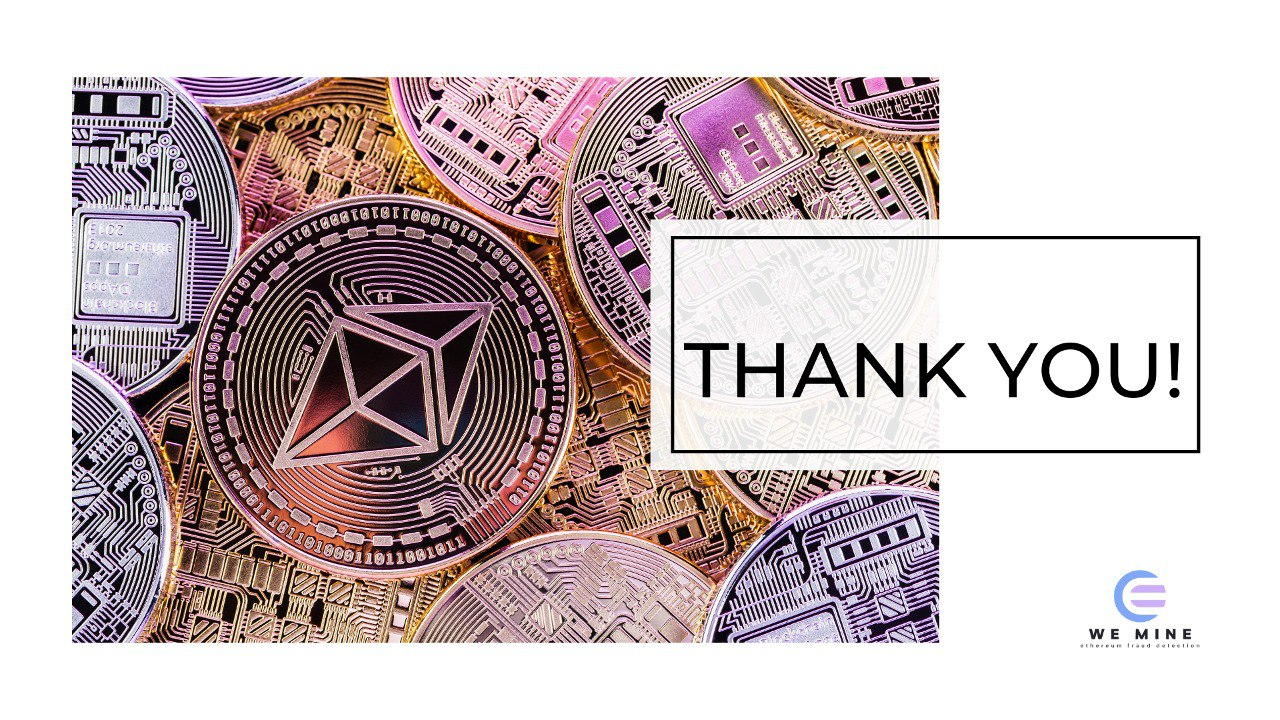

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="second-mid-term")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/c-ambrosi/second-mid-term


'https://jovian.ai/c-ambrosi/second-mid-term'